$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\renewcommand{\expect}[1]{\left\langle{#1}\right\rangle{}}$$
$$\renewcommand{\inner}[1]{\langle{#1}|\rangle{#1}}$$
$$\renewcommand{\expectfull}[2]{\left\langle{#1}\right|{#2}\left|{#1}\right\rangle}$$

# Project 6: Determination of the Ground-State of the Lennard Jones Potential
This project uses a Monte-Carlo Variational method to find the approximate wavefunction of an arbitrary potential in 1-D.

## Objective:

The interaction between neutral, nonpolarized atoms is modelled by the so-called _Lennard-Jones Potential_, which is a radial potential given by

$$V(r) = 4\varepsilon \left(\left[\frac{\sigma}{r}\right]^{12}-\left[\frac{\sigma}{r}\right]^{6}\right)$$

where $\varepsilon$ is the bonding energy, $\sigma$ is the van der Waals radius, and $r$ is the separation distance between the two particles.

Many methods can be employed to determine the properities of an electron that resides in this potential, however we will be focusing in on the Variational Method. This is the process by which a trial wavefunction $\ket{\psi_{\text{trial}}}$ is assumed to fit within the bounds of the well. This wavefunction is characterized by adjustable fit parameters $(\alpha, \gamma, \beta, ...)$ that change to optimize the energy expectation value $\expect{E}$. The choice is not completely arbitrary, as it is important to predict the behavior of the guess at the boundaries of the well- namely that it converges to some value. Once a sufficient trial function is determined, we minimize the expectation value of energy with respect to the adjustable parameters

$$\nabla_{\alpha, \beta, \gamma,...}\frac{\expectfull{\psi_{\text{trial}}}{H}}{\langle{\psi_{\text{trial}}}|{\psi_{\text{trial}}} \rangle}=0.$$

Returning the values of the parameters that minimize the energy and plugging them back into $\expect{E}$ gives an upper bound on the energy. 

**Our goal is to create a random trial wavefunction array $\psi_{i}$, pick a random array element $i$, nudge the value of the wavefunction up or down, examine the energy expectation value and see if it increases or decreases. We discard changes to the wavefunction that increase the energy and keep changes that decrease the energy.**

We do this until the changes to the energy fall within some threshold and then return the final wavefunction.

### Task:

1. Descritize $\expect{E}$ and write a function that calculates it. 

2. Create a function that generates a random trial wavefunction of length $N=100$ assuming that (in atomic units) the bonding energy is $\varepsilon = 10$, van der Waals radius is $\sigma=1$, and the bounds are $[0.8, 8]\sigma$. 

3. Plot the LJP given the parameters above with the trial wavefunction.

4. Implement the variational method as outlined in the description (note the bolded text).

5. Plot 
    1. The wavefunction for $2^{k}~\text{where}~k \in \mathbb{Z} = [1,13]$ random nudges.
    2. The energy as a function of evaluations.

6. Generate the following trial wavefunction and perform $2^{11}$ random nudges

    $$ \psi_{i}=
    \begin{cases}
    0~\text{for}~0<i<5\\
    0.5~\text{for}~5<i<N/5\\
    0~\text{for}~N/5<i<N
    \end{cases}$$

    Is the convergence faster? Why or why not?

    1. How do the wavefunctions and energies compare? Which one do you think is closer to the correct wavefunction?

7. What is the advantage to using this approach? Disadvantages?

8. Create a new radial grid centered about zero from $[-4,4]\sigma$. Using the method we developed, would it work for the Harmoic Oscillator Potential where $\omega = \varepsilon/5$? Infinite square well bounded between $-2\sigma<x<2\sigma$? Verify the results to the exact answers.

## Solution:

First we import the packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

1. The normalization factor $\langle{\psi_{\text{trial}}}|{\psi_{\text{trial}}}\rangle^{-1}$ can be rewritten as

$$C = \frac{1}{\sqrt{\sum_{i=0}^{n-1}\psi_{i}^{2}}},$$

and the numerator can be expanded as the time-independent Schrodinger equation (in atomic units) with a central-difference representation

$$\expect{E}\approx C\sum_{i=0}^{n-1}\left[\left(\psi_{i+1}-2\psi_{i}+\psi_{i-1}\right)\delta r^{-2}+V(r)\psi_{i}\right]\psi_{i}\delta r$$

where $i$ is the index, $n$ is the length of the array, $\delta r$ is the interval size of the radius. 

We can create a function that normalizes some input array

In [2]:
def normalize(guess):
    return guess / np.sqrt(np.sum(guess*guess))

And then call this function when we find the expectation value of the array

In [3]:
def expectation(guess, potential, r):
    dr = np.diff(r)[0]
    norm_trl = normalize(guess)                   
    
    Ef = dr*(potential[0]*norm_trl[0]**2-(1/2)*norm_trl[0]*
                  (norm_trl[2]+norm_trl[1]-2*norm_trl[0])/dr**2)
    # Calculates the energy at the first index using Forwards-Difference
    Eb = dr*(potential[-1]*norm_trl[-1]**2-(1/2)*norm_trl[-1]*
                  (norm_trl[-1]+norm_trl[-3]-2*norm_trl[-2])/dr**2)
    # Calculates the energy at the last index using Backwards-Difference
    E0 = dr*np.sum((potential[2:]*norm_trl[1:-1]**2-(1/2)*norm_trl[1:-1]*
                (norm_trl[2:]+norm_trl[0:-2]-2*norm_trl[1:-1])/dr**2))
    # Calculates the energy using the Central-Difference
    return E0+Ef+Eb # Returns the <E>

2. First, we can set up the constants and grid for our calculation.

In [4]:
length = 100 # Length of array
sigma = 1    # vdW Radius (Width of well)
epsilon = 10 # Bonding energy (Depth of well)
r = np.linspace(0.8, 8, length)*sigma # Radial grid

The initial wavefunction is largely arbitrary, so we can create a noisy array that is bounded at the ends

In [5]:
def trial(length):
    return np.array([*[0]*3, *np.random.rand(length-6), *[0]*3])

And the LJP is simply

In [6]:
def ljp(r, epsilon, sigma):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

3. Now we can plot the potential and the start of our wavefunction:

In [7]:
guess = trial(length)
potential= ljp(r, epsilon, sigma)

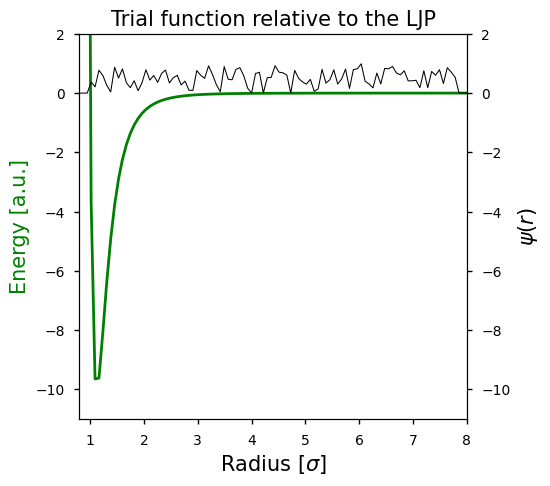

In [8]:
with plt.style.context("seaborn-notebook"):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
    ay = ax.twinx()
    ax.plot(r, potential, color='g', linewidth = 2)
    ay.plot(r, guess, color='k', linewidth = 0.75)

    ax.set_xlim([r[0], r[-1]])
    ax.set_ylim([-11, 2])

    ay.set_xlim([r[0], r[-1]])
    ay.set_ylim([-11, 2])

    ax.set_xlabel("Radius [$\\sigma$]", fontsize=15)
    ax.set_ylabel("Energy [a.u.]", fontsize=15, color='g')

    ay.set_ylabel("$\\psi(r)$", fontsize=15, color='k')

    ax.set_title("Trial function relative to the LJP", fontsize=15)
plt.show()

Note that we bound the ends of the wavefunction to zero because the left-most side as the radius approaches zero is extremely repulsive, so there would be a low probability of the electron existing in that region, and the right-most side eventually converges to zero potential, so the wavefunction would look for a region of lower energy.

4. Our algorithm depends on four factors (1) the initial guess wavefunction (2) the defined potential (3) the grid of radial points (4) the number of nudges or "evaluations" we perform. Below performs the calculation as outlined in the description, comments describe each component

In [9]:
def variational(guess, potential, r, evaluations):
    E0 = expectation(guess, potential, r) # Find the expectation value of the initial guess  
    store = guess.copy() # Create a back-up copy of the guess in case nudge fails
    E_after = 0 # Initialize the comparison energy
    
    while evaluations>0:  # While the counter is above zero
        
        # if evaluations%10 == 0: # Debug convergence
        #         print(evaluations)
        
        rdx =  np.random.randint(1, len(r)-2) # Pick a random index that isn't at the end-points
        store[rdx] = guess[rdx] # Remember the guess before it is changed
        dpsi = (np.random.rand()-0.5)*0.85 # Create a nudge (-0.5,+0.5) with some resolution
        guess[rdx] = guess[rdx]+dpsi # Nudge the wavefunction
        E_after = expectation(guess, potential, r) # Look at the energy
        
        if E_after>E0: # If it got larger
            guess[rdx] = store[rdx] # Revert to previous value
        else: # If it got smaller
            evaluations-=1 # Count down the number of sucessfull nudges
            E0 = E_after # Set the new accepted energy and loop
            
    return normalize(guess), E0# Normalize the returned wavefunction and the energy associated to it


At the end, we return a wavefunction that is normalized and the upper bound of energy. We can verify the normalization by choosing an arbitrary number of evaluations and checking

$$\int_{-\infty}^{\infty}~dr\left|\psi(r)\right|^{2}=1$$

In [10]:
psi_random, E_random = variational(guess, potential, r, 2**11)
np.trapz(psi_random**2)

1.0000000000000002

5. Using the algorithm we made, we can loop over an array of evaluations and examine how the wavefunction and energy converge.

In [11]:
n = 13
evaluations = 2**np.array([i+1 for i in range(n)])
psi_evaluations = np.zeros((n, length))
energy_evaluations = np.zeros(n)
for idx, i in enumerate(evaluations):
    # print(idx) # Debug Convergence
    psi, E = variational(guess, potential, r, i)
    psi_evaluations[idx] = psi
    energy_evaluations[idx] = E

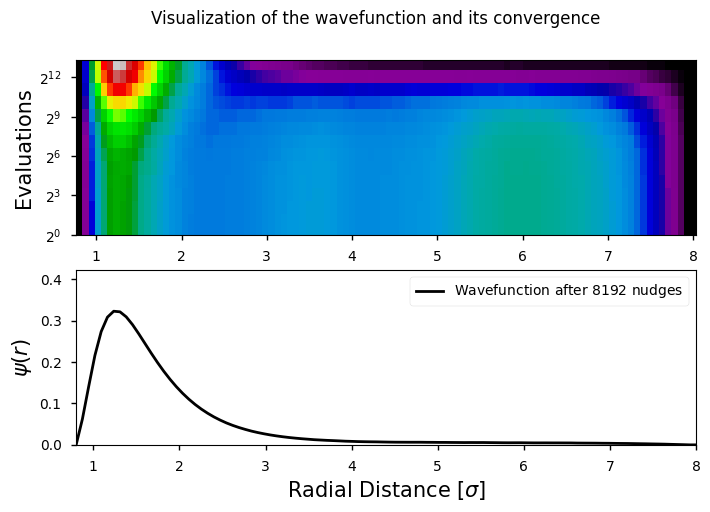

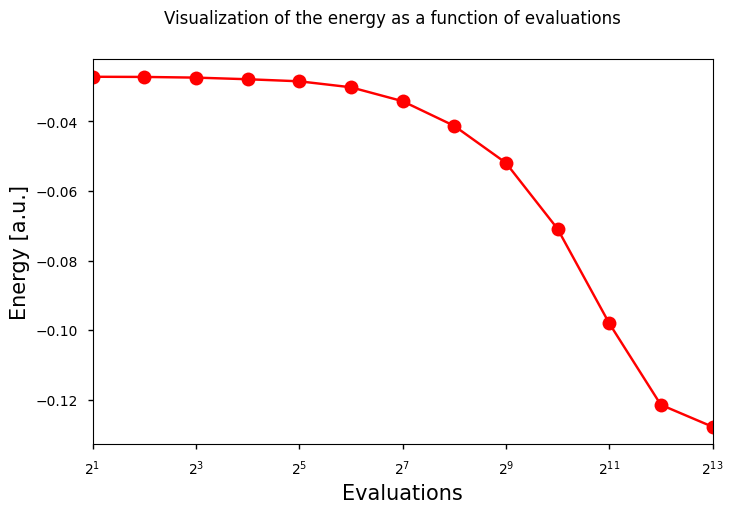

In [12]:
with plt.style.context("seaborn-notebook"):
    fig, ax = plt.subplots(ncols=1, nrows=2,figsize=(8,5))
    fig.suptitle("Visualization of the wavefunction and its convergence")
    ax[0].pcolormesh(r, evaluations, psi_evaluations, cmap="nipy_spectral")
    ax[0].set_yscale("log", base=2)
    
    ax[1].plot(r, psi_evaluations[-1], color="k", linewidth=2, label=f"Wavefunction after ${2**n}$ nudges")
    
    ax[1].set_xlim([r[0], r[-1]])
    ax[1].set_ylim([0, np.max(psi_evaluations[-1])+0.1])
    
    ax[0].set_ylabel("Evaluations", fontsize=15)
    ax[1].set_ylabel("Evaluations", fontsize=15)
    ax[1].set_ylabel("$\\psi(r)$", fontsize=15, color='k')
    ax[1].set_xlabel("Radial Distance [$\\sigma$]", fontsize=15, color='k')
    
    ax[1].legend(loc="best")
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.suptitle("Visualization of the energy as a function of evaluations")
    ax.plot(evaluations, energy_evaluations, color='r', marker="o", markersize=10)
    ax.set_xscale("log", base=2)
    ax.set_xlim([evaluations[0], evaluations[-1]])
    ax.set_ylabel("Energy [a.u.]", fontsize=15, color='k')
    ax.set_xlabel("Evaluations", fontsize=15, color='k')
    
plt.show()

6. We create a function that generates a square trial function at the indicated regions.

In [13]:
def trial_square(length):
    trl = np.zeros(length) 
    for i in range(5, int(length/5)): 
        trl[i] = 0.5
    return trl

In [14]:
psi_square, E_square = variational(trial_square(length), potential, r, 2**11)
np.trapz(psi_random**2)

1.0000000000000002

The square wavefunction takes almost 3 orders of magnitude longer to converge to a satisfactory answer even though it mimics the shape of the actual wavefunction roughly from the first step. This is a side-effect of the algorithm, which favors completely random starting arrays. Every nudge that creates a favorable energy change eats away at the total evaluation count, so for noisy and absurd starting guesses, the counter diminishes rapidly. If the guess is close to the actual answer, however, convergence can be slowed because these random nudges are more likely to create an unfavorable change in energy, so more guesses have to be discarded before a successful one is kept. As a result the final calculated wavefunction is closer to the actual at the expense of time.

If we examine the energies, we can see that even though a bad guess was chosen for the random array, the percent difference relative to the good guess is still low

In [15]:
print(f"Pecent Difference = {abs((E_random-E_square)/E_square)*100} %")

Pecent Difference = 78.7613431945185 %


And the wavefunctions compare as the following

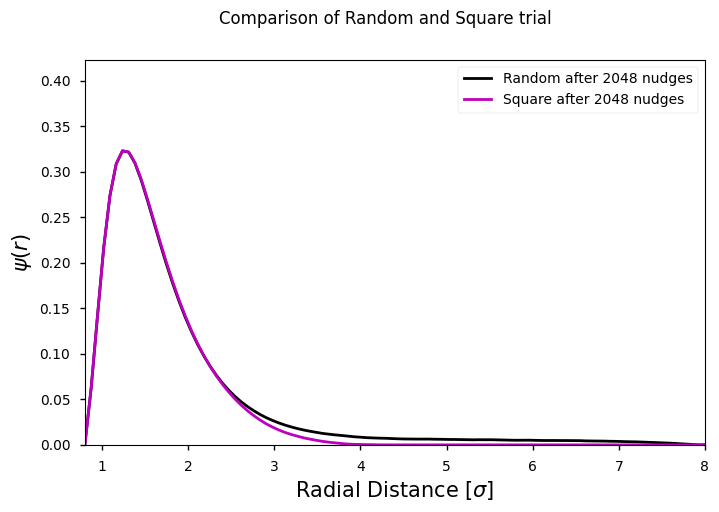

In [16]:
with plt.style.context("seaborn-notebook"):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
    fig.suptitle("Comparison of Random and Square trial")
    ax.plot(r, psi_evaluations[-1], color="k", linewidth=2, label=f"Random after {2**11} nudges")
    ax.plot(r, psi_square, color="m", linewidth=2, label=f"Square after {2**11} nudges")
    
    ax.set_xlim([r[0], r[-1]])
    ax.set_ylim([0, np.max(psi_evaluations[-1])+0.1])
    
    ax.set_xlabel("Radial Distance [$\\sigma$]", fontsize=15)
    ax.set_ylabel("$\\psi(r)$", fontsize=15, color='k')
    
    ax.legend(loc="best")
    
plt.show()

7. There are immediately obvious advantages and disadvantages to this method.

### Advantages:
- Works for a one dimensional arbitrary potential
- Unnecessary to know the shape of the wavefunction _a priori_.
- Rapid convergence to a good answer for a bad guess.
- No need to solve the Schrodinger Equation or use memory intensive matrix calculations to get an approximate wavefunction.
- Excited states can be found by accounting for the orthoganality of the lower states (not included here).

### Disadvantages:
- Only works for time-independent potentials (time-dependent systems become nontrivial, see <a href="https://iopscience.iop.org/article/10.1088/1742-6596/99/1/012009/pdf">here</a>).
- Slow convergence for "good" guesses.
- Returns a wavefunction that yields the upper-bound of energy for that state.


8. Our last goal is to verify the claim that this works for arbitrary one dimensional potentials. Because we know the ground state wavefunctions of both the Harmonic Oscillator and Finite Square well, we can check to see if this returns solutions that are close.

First we define the harmonic oscillator potential and create a new radius range to evaluate (still of length 100)

In [17]:
r_new = np.linspace(-4,4,100)*sigma

In [18]:
def harmonic(r):
    return 1/2*(epsilon/5)**2*(r)**2

In [19]:
def finite(r, epsilon):
    well = np.zeros(len(r))
    well[0:len(r)//4] = 10_000
    well[len(r)//4:3*len(r)//4] = -epsilon
    well[3*len(r)//4:4*len(r)//4] = 10_000
    return well

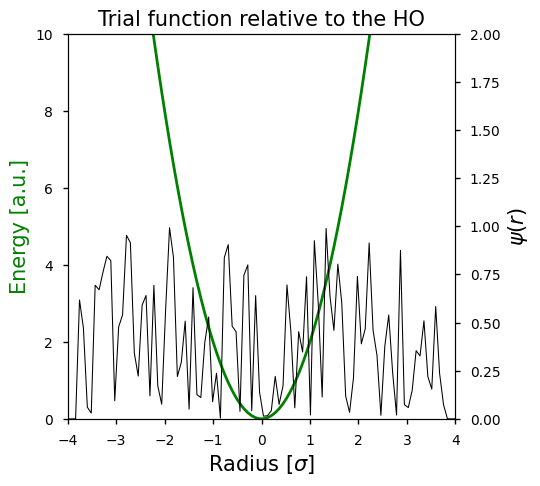

In [20]:
guess_harmonic = trial(length)
potential_harmonic = harmonic(r_new)
with plt.style.context("seaborn-notebook"):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
    ay = ax.twinx()
    ax.plot(r_new, harmonic(r_new), color='g', linewidth = 2)
    ay.plot(r_new, guess_harmonic, color='k', linewidth = 0.75)

    ax.set_xlim([r_new[0], r_new[-1]])
    ax.set_ylim([0, 10])

    ay.set_xlim([r_new[0], r_new[-1]])
    ay.set_ylim([0, 2])

    ax.set_xlabel("Radius [$\\sigma$]", fontsize=15)
    ax.set_ylabel("Energy [a.u.]", fontsize=15, color='g')

    ay.set_ylabel("$\\psi(r)$", fontsize=15, color='k')

    ax.set_title("Trial function relative to the HO", fontsize=15)
plt.show()

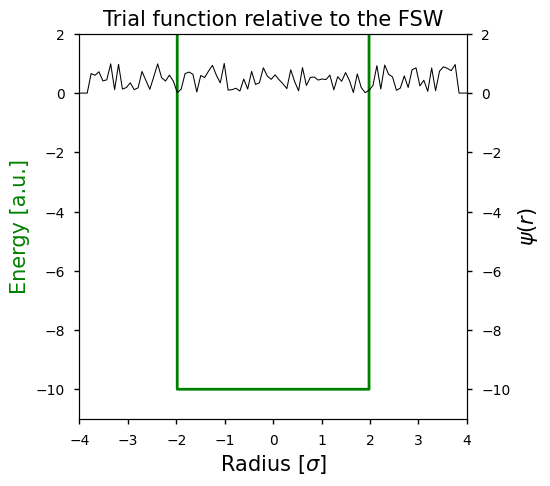

In [21]:
guess_finite = trial(length)
potential_finite = finite(r_new, epsilon)
with plt.style.context("seaborn-notebook"):    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
    ay = ax.twinx()
    ax.plot(r_new, finite(r_new, epsilon), color='g', linewidth = 2)
    ay.plot(r_new, guess_finite, color='k', linewidth = 0.75)

    ax.set_xlim([r_new[0], r_new[-1]])
    ax.set_ylim([-11, 2])

    ay.set_xlim([r_new[0], r_new[-1]])
    ay.set_ylim([-11, 2])

    ax.set_xlabel("Radius [$\\sigma$]", fontsize=15)
    ax.set_ylabel("Energy [a.u.]", fontsize=15, color='g')

    ay.set_ylabel("$\\psi(r)$", fontsize=15, color='k')

    ax.set_title("Trial function relative to the FSW", fontsize=15)
plt.show()

In [22]:
psi_harmonic, E_harmonic = variational(guess_harmonic, potential_harmonic, r_new, 2**12)
np.trapz(psi_harmonic**2)

0.9999999999999999

Given the harmonic oscillator potential

$$V(x) = 1/2 m \omega^{2}x^{2},$$

where $m$ is the particle mass, and $\omega$ is the angular frequency, the exact wave function is known

$$\psi_{\text{HO}}(x) = \left(\frac{m\omega}{\pi \hbar}\right)^{1/4}e^{-\frac{m\omega x^2}{2\hbar}}.$$

In our case, we work in atomic units, so $m=\hbar=1$, and we defined $\omega = \varepsilon/5$ so we have

In [23]:
psi_actual_ho = normalize(((epsilon/5)/np.pi)**(1/4)*np.exp(-(epsilon*r_new**2)/(4)))
E_actual_expect = expectation(psi_actual_ho, potential_harmonic, r_new)
np.trapz(psi_actual_ho**2)

0.9999999999999999

In [24]:
print(f"Percent Error for Energy {abs((E_harmonic-E_actual_expect)/E_actual_expect)*100} %")

Percent Error for Energy 30.057821348391762 %


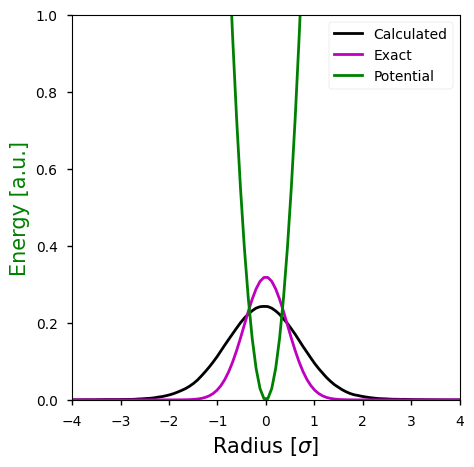

In [25]:
with plt.style.context("seaborn-notebook"):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
    ax.plot(r_new, psi_harmonic, color='k', linewidth=2, label="Calculated")
    ax.plot(r_new, psi_actual_ho, color='m', linewidth=2, label="Exact")
    ax.plot(r_new, potential_harmonic, color="g", linewidth=2, label="Potential")
    
    ax.set_xlim([r_new[0], r_new[-1]])
    ax.set_ylim([0, 1])
    
    ax.set_xlabel("Radius [$\\sigma$]", fontsize=15)
    ax.set_ylabel("Energy [a.u.]", fontsize=15, color='g')
    
    ax.legend(loc="best")
plt.show()

Now we perform the same task for the finite square well

In [26]:
psi_finite, E_finite = variational(guess_finite, potential_finite, r_new, 2**12)
np.trapz(psi_finite**2)

1.0

For the infinite square well bounded between $-2\sigma<x<2\sigma$, we expect

$$\psi(x) = \sqrt{\frac{2}{L}}\cos\left(\frac{n\pi x}{L}\right),$$

where $L$ is the width of the well, and $n$ is the state. With $n=1$ we find

In [27]:
L = np.abs(r_new[len(r)//4]-r_new[3*len(r)//4])
psi_actual_fi = np.sqrt(2/L)*np.cos(1*np.pi*r_new/L)
psi_actual_fi[:len(r)//4],  psi_actual_fi[3*len(r)//4:] = 0, 0
psi_actual_fi = normalize(psi_actual_fi)

E_actual_expect = expectation(psi_actual_fi, potential_finite, r_new)

In [28]:
print(f"Percent Error for Energy {abs((E_finite-E_actual_expect)/E_actual_expect)*100} %")

Percent Error for Energy 4.241990127483738 %


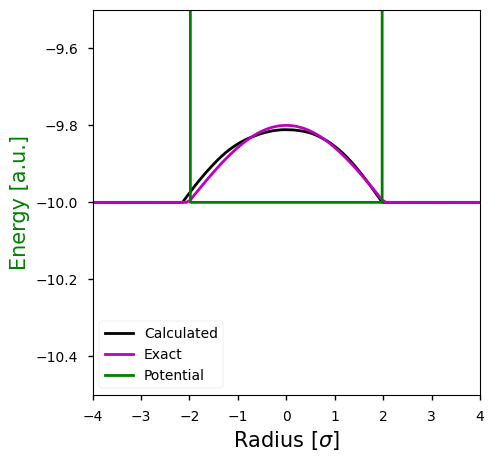

In [29]:
with plt.style.context("seaborn-notebook"):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
    ax.plot(r_new, psi_finite-10, color='k', linewidth=2, label="Calculated")
    ax.plot(r_new, psi_actual_fi-10, color='m', linewidth=2, label="Exact")
    ax.plot(r_new, potential_finite, color="g", linewidth=2, label="Potential")
    
    ax.set_xlim([r_new[0], r_new[-1]])
    ax.set_ylim([-10.5, -9.5])
    
    ax.set_xlabel("Radius [$\\sigma$]", fontsize=15)
    ax.set_ylabel("Energy [a.u.]", fontsize=15, color='g')
    
    ax.legend(loc="best")
plt.show()

This method clearly works within some margin of error to give quick representations of what the wavefunction of a system is.